## More than Meets the Ear: The Data and Elements Behind Spotify Songs
Since its humble beginnings in Sweden, **Spotify** has continually grown exponentially to become one of, if not, the world's biggest music streaming provider. Boasting an immense catalog of tracks from around the world, the music giant has gathered mounds of valuable data, both basic and complex, behind the songs deployed in its massive database. For this Notebook, the researchers **Anjelo Antioquia**, **Gabriel Minamedez**, and **Julian Sunpayco** will report their findings in this case study centered around a dataset gathered from online data science community Kaggle related to the songs in Spotify.

This is in partial fulfillment of the course **Statistical Modelling and Simulation (CSMODEL)**.

## Import
Import Python modules. **IPython** is for an embedded HTML file in the Exploratory Data Analysis portion. **matplotlib**, **numpy**, **pandas**, **scipy**, **seaborn**, and **sklearn** are for data handling, analysis, and visualization.

In [1]:
from IPython.display import IFrame
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import seaborn as sns
from sklearn.cluster import KMeans

## Dataset: The Spotify Dataset
The [Spotify dataset](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks?select=data.csv) (titled **`data.csv`**) consists of 160,000+ tracks from 1921-2020 found in Spotify as of June 2020. Collected by Kaggle user and Turkish Data Scientist Yamaç Eren Ay, the data was retrieved and tabulated from the **Spotify Web API**. Each row in the dataset corresponds to a track, with variables such as the title, artist, and year located in their respective columns. Aside from the fundamental variables, musical elements of each track, such as the tempo, danceability, and key, were likewise extracted; the algorithm for these values were generated by Spotify based on a range of technical parameters.

Let's bring in that dataset now:

In [2]:
main_df = pd.read_csv("./data.csv")
main_df.head()

,id,name,artists,duration_ms,release_date,year,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,mode,key,popularity,explicit
0,6KbQ3uYMLKb5jDxLF7wYDD,Singende Bataillone 1. Teil,['Carl Woitschach'],158648,1928,1928,0.995,0.708,0.1950,0.563,0.1510,-12.428,0.0506,118.469,0.7790,1,10,0,0
1,6KuQTIu1KoTTkLXKrwlLPV,"Fantasiestücke, Op. 111: Più tosto lento","['Robert Schumann', 'Vladimir Horowitz']",282133,1928,1928,0.994,0.379,0.0135,0.901,0.0763,-28.454,0.0462,83.972,0.0767,1,8,0,0
2,6L63VW0PibdM1HDSBoqnoM,Chapter 1.18 - Zamek kaniowski,['Seweryn Goszczyński'],104300,1928,1928,0.604,0.749,0.2200,0.000,0.1190,-19.924,0.9290,107.177,0.8800,0,5,0,0
3,6M94FkXd15sOAOQYRnWPN8,Bebamos Juntos - Instrumental (Remasterizado),['Francisco Canaro'],180760,9/25/28,1928,0.995,0.781,0.1300,0.887,0.1110,-14.734,0.0926,108.003,0.7200,0,1,0,0
4,6N6tiFZ9vLTSOIxkj8qKrd,"Polonaise-Fantaisie in A-Flat Major, Op. 61","['Frédéric Chopin', 'Vladimir Horowitz']",687733,1928,1928,0.990,0.210,0.2040,0.908,0.0980,-16.829,0.0424,62.149,0.0693,1,11,1,0


With a huge array of variables present as seen above, it may seem overwhelming, but don't be! Together, these variables describe a track in each row, giving each some interesting numerical context across different parameters. Below is the list of variables and their descriptions:
- **`id`**: A unique identifier for each track.
- **`name`**: The track's title.
- **`artists`**: Artist/s who participated in the track.
- **`duration_ms`**: Length of the track in milliseconds (ms).
- **`release_date`**: The track's release date in MM/DD/YYYY, or at the minimum, YYYY.
- **`year`**: The year in which the track was released.
- **`acousticness`***: A confidence measure from 0.0 to 1.0 of whether the track is acoustic.
- **`danceability`***: Describes how suitable a track is for dancing. A value of 0.0 is least danceable and 1.0 is most danceable.
- **`energy`***: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast and loud.
- **`instrumentalness`***: Predicts whether a track contains no vocals.
- **`liveness`***: Detects the presence of an audience in the recording.
- **`loudness`***: The overall loudness of a track in decibels (dB).
- **`speechiness`***: Detects the presence of spoken words in a track.
- **`tempo`***: The overall estimated tempo of a track in beats per minute (BPM).
- **`valence`***: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track.
- **`mode`**: Melodic content from the modality of a track. 1 = Major; 0 = Minor.
- **`key`**: The estimated overall key of a track from the [Pitch Class notation](https://en.wikipedia.org/wiki/Pitch_class). E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.
- **`popularity`**: A track's popularity, 0-100 where 100 is the most popular based on [Spotify's algorithm](https://developer.spotify.com/documentation/web-api/reference/tracks/get-track/).
- **`explicit`**: Whether or not the track has explicit lyrics. 1 = True; 0 = False.

*Based on the [audio features of a track from Spotify's Web API](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/).

There are quite a lot of variables here to dissect, however, there are some columns here that will not be relevant to the following Exploratory Data Analysis and the Further Investigation and Inference on the Spotify data. For simplicity's sake, we'll drop those irrelevant variables. In this case, we'll drop the following columns, along with the reason for dropping:
- **`id`**: No further analysis can be drawn from the track's unique identifier.
- **`release_date`**: Since some of the data is incomplete (e.g. no date, no month), this will be dropped as it will be impossible to draw annual trends for time series, thus deeming this variable irrelevant. Filling in date information based on other complete dates will likewise harm the data. We will simply depend on the `year` variable for time analysis.
- **`liveness`**: It is merely a measure of whether or not a track was performed live or through a recording studio, and so the researchers deem this as a non-fundamental musical element since this does not directly measure an element of music itself.

Let's now materialize the deletion of these columns:

In [3]:
main_df.drop(["id", "release_date", "liveness"], axis=1, inplace=True)
main_df.head()

,name,artists,duration_ms,year,acousticness,danceability,energy,instrumentalness,loudness,speechiness,tempo,valence,mode,key,popularity,explicit
0,Singende Bataillone 1. Teil,['Carl Woitschach'],158648,1928,0.995,0.708,0.1950,0.563,-12.428,0.0506,118.469,0.7790,1,10,0,0
1,"Fantasiestücke, Op. 111: Più tosto lento","['Robert Schumann', 'Vladimir Horowitz']",282133,1928,0.994,0.379,0.0135,0.901,-28.454,0.0462,83.972,0.0767,1,8,0,0
2,Chapter 1.18 - Zamek kaniowski,['Seweryn Goszczyński'],104300,1928,0.604,0.749,0.2200,0.000,-19.924,0.9290,107.177,0.8800,0,5,0,0
3,Bebamos Juntos - Instrumental (Remasterizado),['Francisco Canaro'],180760,1928,0.995,0.781,0.1300,0.887,-14.734,0.0926,108.003,0.7200,0,1,0,0
4,"Polonaise-Fantaisie in A-Flat Major, Op. 61","['Frédéric Chopin', 'Vladimir Horowitz']",687733,1928,0.990,0.210,0.2040,0.908,-16.829,0.0424,62.149,0.0693,1,11,1,0


Let's now check the specific information for the variables of this dataset and see if further cleaning is needed:

In [4]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169909 entries, 0 to 169908
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              169909 non-null  object 
 1   artists           169909 non-null  object 
 2   duration_ms       169909 non-null  int64  
 3   year              169909 non-null  int64  
 4   acousticness      169909 non-null  float64
 5   danceability      169909 non-null  float64
 6   energy            169909 non-null  float64
 7   instrumentalness  169909 non-null  float64
 8   loudness          169909 non-null  float64
 9   speechiness       169909 non-null  float64
 10  tempo             169909 non-null  float64
 11  valence           169909 non-null  float64
 12  mode              169909 non-null  int64  
 13  key               169909 non-null  int64  
 14  popularity        169909 non-null  int64  
 15  explicit          169909 non-null  int64  
dtypes: float64(8), int64

With 169,909 tracks in total and every variable filled, it's looking good so far! However, let's dig in some more just in case there are anomalies with the data themselves. Let's use the `pd.Series.unique()` function to check the variables with limited choices of possible values (rules indicated in comments for each print statement):

In [5]:
print(main_df["mode"].unique()) # Should be either 0 or 1
print(main_df["key"].unique()) # Should be values from 0 to 11
print(main_df["explicit"].unique()) # Should be either 0 or 1

[1 0]
[10  8  5  1 11  6  9  7  4  2  3  0]
[0 1]


It looks like the variables `mode`, `key`, and `explicit` are good to go. Let's now check the variables supposedly bound within a given range:

In [6]:
print(str(main_df["year"].min()) + " – " + str(main_df["year"].max())) # Range: [1921 – 2020]
print(str(main_df["acousticness"].min()) + " – " + str(main_df["acousticness"].max())) # Range: [0.0 – 1.0]
print(str(main_df["danceability"].min()) + " – " + str(main_df["danceability"].max())) # Range: [0.0 – 1.0]
print(str(main_df["energy"].min()) + " – " + str(main_df["energy"].max())) # Range: [0.0 – 1.0]
print(str(main_df["instrumentalness"].min()) + " – " + str(main_df["instrumentalness"].max())) # Range: [0.0 – 1.0]
print(str(main_df["speechiness"].min()) + " – " + str(main_df["speechiness"].max())) # Range: [0.0 – 1.0]
print(str(main_df["valence"].min()) + " – " + str(main_df["valence"].max())) # Range: [0.0 – 1.0]
print(str(main_df["popularity"].min()) + " – " + str(main_df["popularity"].max())) # Range: [0 – 100]

1921 – 2020
0.0 – 0.996
0.0 – 0.988
0.0 – 1.0
0.0 – 1.0
0.0 – 0.9690000000000001
0.0 – 1.0
0 – 100


The ranges are all as expected. However, let's check to see if there are any duplicate rows that might skew our data a certain way:

In [7]:
main_df[main_df.duplicated()]

,name,artists,duration_ms,year,acousticness,danceability,energy,instrumentalness,loudness,speechiness,tempo,valence,mode,key,popularity,explicit
609,"Rhapsody on a Theme of Paganini, Op.43: Variat...","['Sergei Rachmaninoff', 'William Kapell', 'Fri...",61467,1945,0.98300,0.635,0.0123,0.955000,-27.297,0.0521,83.046,0.610,1,0,0,0
652,Interview with William Kapell,['William Kapell'],1325093,1945,0.91300,0.704,0.2230,0.000000,-24.480,0.9350,112.485,0.403,0,2,0,0
3344,Give Me Your Love (Love Song),['Curtis Mayfield'],260333,1972,0.12800,0.591,0.6370,0.019500,-9.102,0.0887,172.452,0.962,0,5,26,0
8094,Enamórate De Alguien Más,['Morat'],230040,2020,0.46000,0.591,0.6590,0.000000,-5.464,0.0332,145.997,0.622,1,11,2,0
8169,"Danse macabre, S. 555 (after Camille Saint-Saens)","['Franz Liszt', 'Vladimir Horowitz']",491333,1928,0.99300,0.303,0.2260,0.826000,-21.483,0.0444,67.013,0.146,1,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164200,My Prayer,['Roy Orbison'],164467,1963,0.83800,0.493,0.2170,0.004630,-11.501,0.0271,105.003,0.182,1,9,20,0
166015,Bonzo's Montreux - 2012 Remaster,['Led Zeppelin'],262147,1982,0.21300,0.291,0.9750,0.908000,-10.754,0.0557,180.289,0.127,0,6,33,0
168041,Shiver,['Maroon 5'],179773,2002,0.04210,0.625,0.9250,0.000000,-4.435,0.3420,172.017,0.515,1,0,47,0
169035,Video Games - Remastered,['Lana Del Rey'],281947,2012,0.80600,0.390,0.2550,0.000001,-9.676,0.0299,122.056,0.179,0,6,50,0


Based on the table above, there are 607 rows of duplicated data (not counting the first recorded instance for each). It's best to drop these rows since multiple instances of the same song will compromise our Exploratory Data Anaylsis and Research in searching for trends. We shall use `drop_duplicates` for that:

In [8]:
main_df.drop_duplicates(inplace=True)
main_df[main_df.duplicated()]

,name,artists,duration_ms,year,acousticness,danceability,energy,instrumentalness,loudness,speechiness,tempo,valence,mode,key,popularity,explicit


After dropping the duplicates, the empty table above indicates that they have completely been removed from our dataset. Looks like this dataset is officially good to go for analysis! We can now move on to the **Exploratory Data Analysis** with the Spotify tracks.

# Exploratory Data Analysis (EDA) on Spotify Data
Being datasets teeming with variables, the researchers have the opportunity to identify trends in the musical elements. It may be in the form of an evolutionary timeline of musical elements between decades. It may also be a comparison of musical elements among genres. From the data, the researchers may also determine assumptions on musical evolution.

The researchers have already done a comprehensive data analysis of the dataset, with the help of the [Pandas Profiling Python module](https://towardsdatascience.com/exploratory-data-analysis-with-pandas-profiling-de3aae2ddff3) that aids specifically for exploratory data analysis. It gives a detailed exploratory approach at the data, offering visualizations of the summary statistics, correlations, possible warnings, and much more.

However, with the interest of the project specifications, we will no longer be doing a descriptive deep dive in every summary statistic for this Notebook. Rather, embedded below is the **`spotify_eda.html`** file produced from the aforementioned Pandas Profiling module for you to explore:

In [9]:
IFrame(src="./spotify_eda.html", width=900, height=500)

From the explored data, the researchers have formulated three (3) of the most interesting EDA questions that could aid us in our further research, starting with...

### EDA #1: Studying the correlations between the variables in the Spotify data.
With all the musical elements, it will be intriguing to analyze the correlations between the variables. From those correlations, we can get an idea of the relationships between the variables among songs, as well as get an overview of the progression or regression of these elements spanning different variables, if any.

Let's first visualize these correlations. This is a perfect time to use a **correlation heatmap**, where the variables are the ticks for both dimensions of a 2D graph, mapped with how much a variable correlates with another. For this, we will use **seaborn**'s heatmap tool:

<AxesSubplot:>

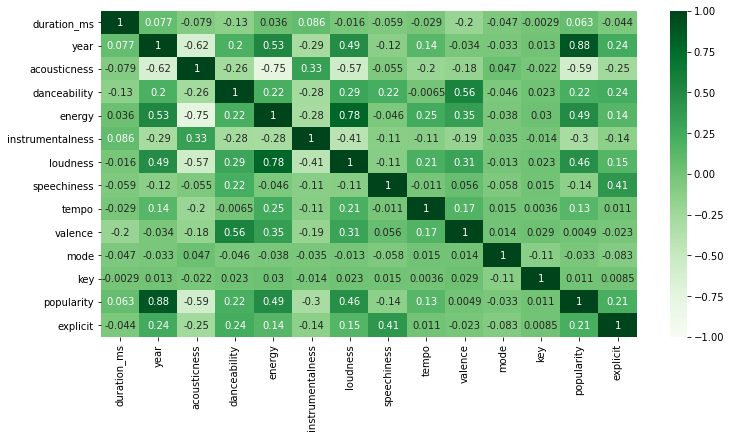

In [10]:
plt.figure(figsize=(12, 6))
sns.heatmap(main_df.corr(), vmin=-1, vmax=1, annot=True, cmap="Greens")

The annotated values for each cell are the measure of the correlation for each cell's corresponding x and y variables. These values are also known as **Pearson's correlation coefficient (PCC)**, where values closer or equal to 1 have a positive linear relationship (i.e. when one variable increases, the other variable likewise increases). If the PCC are closer or equal to -1, this indicates a negative linear relationship (i.e. when one variable increases, the other variable decreases). When the PCC is closer or equal to 0, then there is nearly no linear relationship between the variables.

To simplify our process for analysis, let's set the threshold for the PCC's that we will analyze to those greater than 0.5. We will apply the principle of absolute value for negative values as these likewise indicate the linearity of a relationship.

Naturally, cells having the same x and y variables will have positive linear relationsips, thus the PCC values being equal to 1.

There is a strong PCC value of 0.88 between `year` and `popularity`, which is most likely an effect of Spotify's algorithm on popularity. According to Spotify, a song's `popularity` is based on "the total number of plays the track has had and how recent those plays are". This means that people tend to play more recently released songs, probably due to the marketing efforts of the respective artists and their companies.

There are a notable PCC's involving the `acousticness` of a song. [Acousticness](https://www.merriam-webster.com/dictionary/acoustic#:~:text=1%20%3A%20of%20or%20relating%20to,by%20or%20utilizing%20sound%20waves) is defined as the element of a song that strays away from being electronically modified. Based on the PCC of -0.62 between `year` and `acousticness`, this musical element has seen a dramatic decrease as the years go. This could very well be an effect of technological advancements in the music industry with the [rise of Digital Audio Workstations (DAWs)](https://techterms.com/definition/daw). The popularity in more acoustic songs have also dipped (-0.59 PCC value with `year`. 

With the decline of acousticness comes the rise of the `energy` element in songs, as indicated by a PCC of -0.75 between the two. According to Spotify, part of what defines energy is the `loudness` of a track, and this is seen in its PCC value of 0.78 with `energy` (adversely, a -0.57 PCC with `acousticness`). It seems that energetic tracks have prevailed through the years too, as it posed a 0.53 PCC value with `year`.

A confirming PCC value is that of between `valence` and `danceability`. Valence is described as the positiveness (i.e. happiness) of a song, while danceability is as it is. 

### EDA #2: The evolution of different musical elements through the years.
We've gotten an idea of the correlation of the variables between each other in the previous EDA question. For this, we will focus on the evolution of certain musical features by year. Given the different musical elements provided, it will be interesting to see how these facets have evolved through the years. Are songs faster in pace now?  Has autotune really taken over the industry? How about the general tone of the songs?

The researchers made the call of handpicking 6 of the 8 musical elements, namely `acousticness`, `danceability`, `energy`, `instrumentalness`, `speechiness`, and `valence` given that these fields are measured at the same confidence range of 0.0 – 1.0. The `loudness` and `tempo`, meanwhile, are measured differently in decibels (dB) and beats per minute (BPM), respectively.

We then create a time series graph for each element in order to display the mean values (by year) of the elements present in all songs grouped through the years. Since we have 6 elements to explore, we should have 6 line graphs in total, plotted in a subplot `sp1` (a feature of the **matplotlib** module to show multiple graphs in one cell):

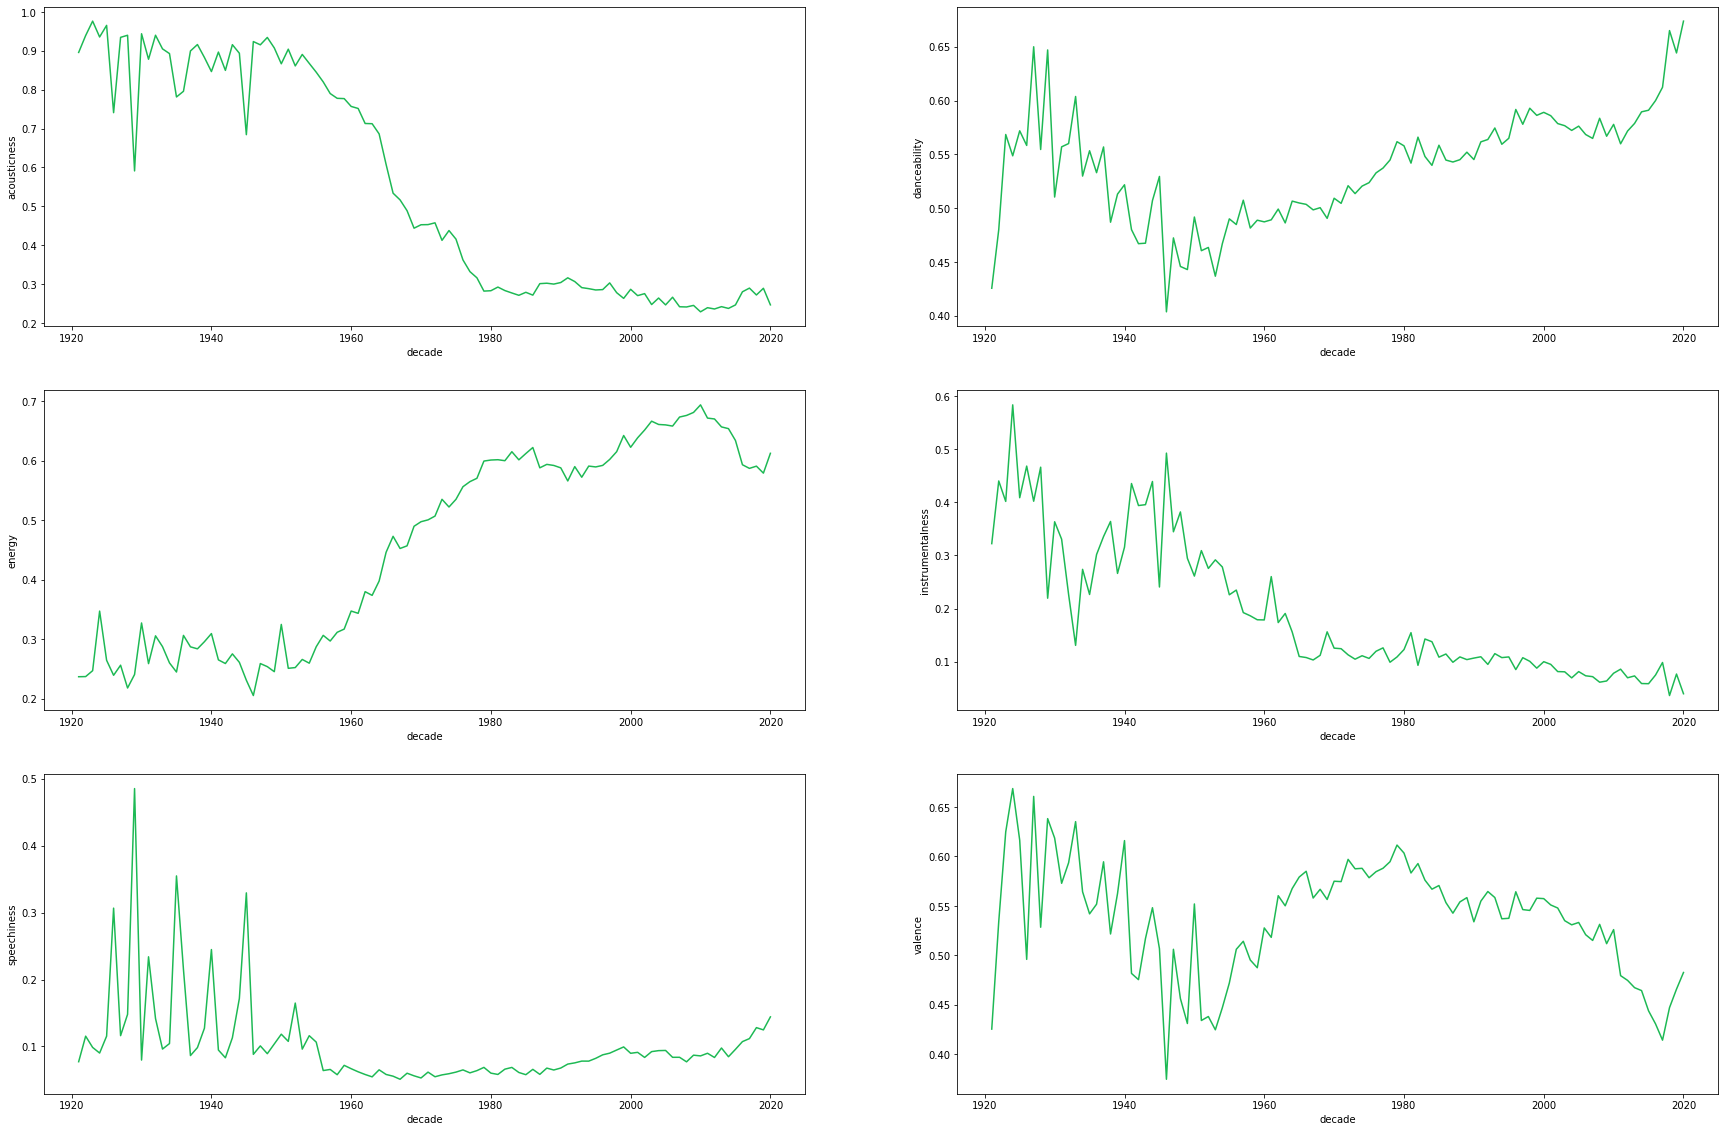

In [11]:
sp1, elements = plt.subplots(3, 2) # Initiate the subplots

arrElements = ["acousticness", "danceability", "energy", "instrumentalness", "speechiness", "valence"]
row = 0
col = 0

for elem in arrElements: # Produce a line graph for each musical element
    main_df.groupby("year")[elem].mean().plot(ax=elements[row][col], figsize=(30,20), color="#1db954") # Group rows by year and get the mean values for that particular element
    elements[row][col].set_xlabel("decade")
    elements[row][col].set_ylabel(elem)
    if col == 0:
        col = 1
    elif row == 0 and col == 1:
        row = 1
        col = 0
    elif row == 1 and col == 1:
        row = 2
        col = 0

Quite a lot of graphs to unpack here, but let's run through them one by one and make some discoveries on the data.

First and foremost, we can see a dramatic decrease in the areas of `acousticness` and `instrumentalness` through the years. These could be attributed to the **rise of electrical and electronic music in the mid-20th century**. For both elements, we see a gradual decrease in the 50's, followed by a sharp fall beginning in the 60's – a decade of musical breakthroughs with the rise of [synthesizers in music production](https://www.timetoast.com/timelines/history-of-electronic-music-timeline) and [rock music](https://www.rollingstone.com/music/music-features/bob-dylan-the-beatles-and-the-rock-of-the-sixties-176221/). This adversely affected the `energy` element, which saw a drastic upward trend in about the same time. This is because higher energy levels are typically attributed to having traits of being fast and noisy, scoring high in genres such as **death metal** and **electronic dance music (EDM)**.

As shown by how the trend for synthesized increased, the `speechiness` of the songs have decreased since the synthetic melody of advance technology have grown into trend.

`danceability` has sustained generally high levels in music through the years, however, there is a noticeable drop in the mid-40's to 50's. This was probably a side-effect of [post-war modernism](https://www.theguardian.com/music/tomserviceblog/2013/oct/04/music-in-the-post-second-war-world-tom-service), where music gravitated upon a more somber, heroic tone to fit the mood of the wake of **World War 2**, the deadliest war in history.

Similar to danceability, `valence`, which is a measure of how positive (i.e. happy) a song is, likewise saw a sharp decrease in the post-war era. It saw an upward trend, particularly around the mid-50's to 70's that could have been because of the **hippie music** genre that had its [moment as an opposing force of peace to the United States' involvement in the Vietnam War](https://www.britannica.com/topic/hippie).

### EDA #3: The divide between explicit and non-explicit songs through the years.
There has been a significant uptick in songs containing explicit lyrics with the rise of more liberal and experimental approaches to music as a form of expression. For this analysis, we aim to compare the trend between explicit and non-explicit songs through the years.

Let's start by creating a stacked bar plot to discern differences in the explicitness of the songs:

Text(0.5, 1.0, 'Bar plot of explicit vs. non-explicit songs on Spotify through the years.')

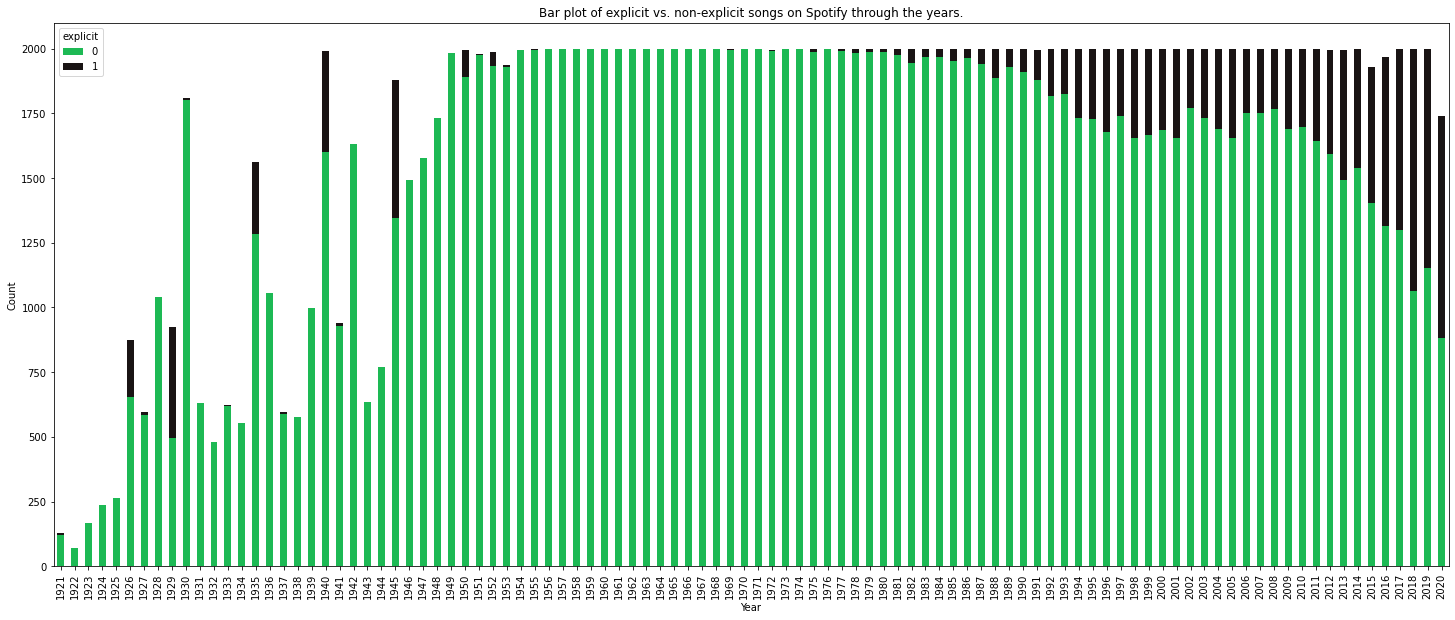

In [12]:
main_df.groupby(["year", "explicit"]).size().unstack().plot(kind="bar", stacked="True", figsize=(25,10), color=["#1db954", "#191414"])
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Bar plot of explicit vs. non-explicit songs on Spotify through the years.")

Based on the bar plot where '0' corresponds to non-explicit songs and vice versa, there's a noticeable development of the amount of explicit songs particularly in the entrance of the 90's, a trend that has sustained in favor of explicit songs until the present year. let's tabulate that data to see the actual numbers:

In [13]:
pd.set_option('display.max_columns', None) # Jupyter display setting
pd.set_option('display.expand_frame_repr', False) # Jupyter display setting
pd.set_option('max_colwidth', None) # Jupyter display setting
explicits = main_df.groupby("explicit")["year"].value_counts() # Get the count between explicit and non-explicit songs by year
pd.DataFrame([explicits[0], explicits[1]], index=["not explicit", "explicit"]) # Convert to DataFrame

year,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
not explicit,121.0,72.0,169.0,237.0,263.0,655.0,584.0,1039.0,494.0,1803.0,630.0,479.0,620.0,554.0,1285.0,1054.0,589.0,576.0,999.0,1601.0,928.0,1631.0,634.0,768.0,1344.0,1493.0,1579.0,1730.0,1982.0,1890.0,1974.0,1934.0,1929.0,1996.0,1995.0,1999.0,2000.0,2000.0,2000.0,1999.0,2000.0,2000.0,1998.0,1997.0,1997.0,2000.0,1999.0,2000.0,1995.0,1997.0,1998.0,1992.0,1998.0,1998.0,1988.0,1998.0,1990.0,1984.0,1985.0,1986.0,1974.0,1945.0,1967.0,1966.0,1953.0,1965.0,1940.0,1885.0,1927.0,1909.0,1877.0,1816.0,1824.0,1730.0,1729.0,1677.0,1740.0,1653.0,1668.0,1684.0,1655.0,1770.0,1730.0,1690.0,1654.0,1753.0,1752.0,1765.0,1689.0,1698.0,1642.0,1591.0,1491.0,1540.0,1402.0,1313.0,1301.0,1063.0,1152.0,881.0
explicit,7.0,NaN,NaN,NaN,NaN,219.0,12.0,NaN,430.0,8.0,NaN,NaN,2.0,NaN,277.0,NaN,7.0,NaN,NaN,391.0,10.0,NaN,NaN,1.0,536.0,1.0,NaN,NaN,NaN,105.0,5.0,54.0,6.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,3.0,NaN,1.0,NaN,4.0,1.0,1.0,4.0,2.0,2.0,12.0,2.0,10.0,16.0,14.0,13.0,26.0,53.0,32.0,34.0,47.0,35.0,59.0,115.0,73.0,91.0,119.0,184.0,176.0,270.0,271.0,323.0,260.0,347.0,332.0,316.0,345.0,229.0,269.0,310.0,345.0,247.0,248.0,234.0,311.0,300.0,358.0,403.0,504.0,458.0,528.0,656.0,698.0,936.0,848.0,860.0


Based on the tabulated data, the presence of explicit songs can be seen as consistent and steadily increasing since the beginning of the 80's. This could be because of the advent of [Hip-Hop music](https://www.englishclub.com/vocabulary/music-hip-hop.html) that started in the Bronx, New York City in the late 70's. Being one of the more controversial yet artistic genres for its liberal expression, Hip-Hop has garnered its fair share of criticisms due to its **explicit mentions of drugs, vices, and sex**.

Going back to the data, the notable outlier years are 1926, 1929, 1935, 1940, and 1945, being the lone years that have reached > 100 explicit tracks before the Hip-Hop era. The researchers have found that the genre of **dirty blues** rose around those times, being [earlier documents of predominantly male artists singing sexually suggestive lyrics](https://tonedeaf.thebrag.com/the-1930s-the-dirtiest-decade-in-music/). It is because of this that some musical experts have tagged the 1930's as one of the dirtiest music eras.

## Further Investigation and Inference (FII) on Spotify Data
The Exploratory Data Analysis we just conducted gave us a good idea of what the Spotify data contains: what each observation represents, and given its variables, the context behind the data. These processes gave us insights on the trends and movements in different musical elements spanning various contexts such as time and correlation.

As the music industry moves forward in its ever malleable state, **doing further investigation and drawing inferences** from the unpacked Spotify data could give us an even better idea on how music has evolved through the years, and how the shift will be moving forward.

We have formulated three (3) research question centered around the data. The answers to these questions shall give the dataset more structure and validate (or invalidate) inferences on various musical variables, starting with...

### FII #1: Determining if there is a significant difference in popularity between explicit and non-explicit songs.
In the third EDA question, we visualized the growing trend of explicit songs that were particularly signficant and consistent in the 80's up until now. By this, we assume that songs with explicit content are produced because they are growing in popularity.

Fortunately, with our data, we have the tools to determine **whether or not there is a significant difference in popularity** between explicit and non-explicit songs. Let us first visualize the summary statistics between the two categories of explicitness with box plots:

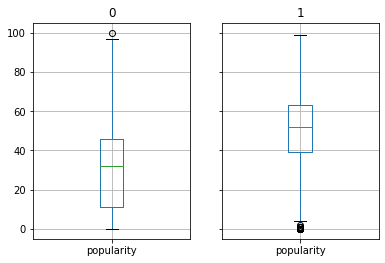

In [14]:
main_df.groupby("explicit").boxplot(column="popularity")
plt.show()

In the box plot for non-explicit tracks, the average popularity lies around the 30-35 range, quite lower than that of explicit tracks whose average popularity lies around the 45-50 range. There are also multiple outliers in the lower popularity spectrum of explicit songs. Let's tabulate the main summary statistics:

In [15]:
main_df.groupby("explicit").agg({"popularity": ["mean", "median", "std", len]})

popularity                          
               mean median        std     len
explicit                                     
0         30.255052     32  20.909213  154890
1         46.735359     52  22.454995   14412

While the popularity of non-explicit songs might very well have been controlled by its dominant count over explicit songs, we can see that there is a tendency that explicit songs are more popular by looking at their average means.

From this, we can determine if the claim that explicit songs are more popular is significant. First, let's get the difference between the mean popularity of the two categories of explicitness:

In [16]:
46.726749 - 30.149842

16.576907

We set up our hypotheses as follows:

$H_0$ (null hypothesis): The true difference is 0.

$H_A$ (alternative hypothesis): The true difference is not 0.

We can use a **t-test** to compare two means from unpaired groups (i.e. unrelated groups). In our case, we compare the popularity values between explicit and non-explicit tracks. This can be achieved with **scipy**'s ttest_ind() function:

In [17]:
ttest_ind(main_df[main_df["explicit"] == 0]["popularity"], main_df[main_df["explicit"] == 1]["popularity"], equal_var=False)

Ttest_indResult(statistic=-84.75522692661204, pvalue=0.0)

We'll be using a significance value of 0.05, meaning that we're setting a 5% chance of risk of claiming that there's a difference between the two means when in fact, there's none.

However, the resulting **p-value** of the t-test is 0.0. Since it is considerably lower than the significance value, we can say that the p-value is statistically significant and that we can reject the null hypothesis. As a result, we can say that **there is a difference in popularity between explicit and non-explicit songs** with the variable being in favor of the former because of its higher mean popularity.

### FII #2: Finding the most frequent emotions in Spotify tracks and analyzing their musical elements based on the track's mode and key.
A key in music is defined as [the minor or major scale around which a musical piece revolves](https://www.studybass.com/lessons/harmony/keys-in-music/#:~:text=In%20music%20a%20key%20is,based%20on%20a%20major%20scale.&text=For%20example%2C%20a%20song%20in,for%20a%20piece%20of%20music.). When combined with tonality (i.e. has a centered sound), a musical piece may exude a certain emotion. This is what makes music beautiful: its ability to speak to people in a melodic way.

From the Spotify dataset, the `mode` and the `key` variables are the building blocks for these very emotions. `mode` corresponds to 0 for a minor key, 1 for a major key, in which both are applicable for each and every possible [pitch class](https://en.wikipedia.org/wiki/Pitch_class) that is defined in `key`. As a result, there are a total of 24 unique mode-key combinations.

Our goal here is to **find the most frequent emotions emitted** from Spotify tracks. From the given mode-key combination from each track, we can achieve this by making use of the principles of **association rules**.

From our dataset, let us first group by each key-mode combination and get the mean value for the numerical variables:

In [18]:
emotions_df = main_df.groupby(["mode", "key"]).agg("mean")
emotions_df

duration_ms         year  acousticness  danceability    energy  instrumentalness   loudness  speechiness       tempo   valence  popularity  explicit
mode key                                                                                                                                                        
0    0    241814.671296  1974.005604      0.575527      0.527936  0.433967          0.216107 -12.281273     0.082894  114.943113  0.502828   29.266569  0.073587
     1    230019.658718  1985.972578      0.375685      0.569310  0.570446          0.150023 -10.053665     0.112924  117.853546  0.524113   38.292399  0.182414
     2    240858.487751  1972.359628      0.584859      0.506273  0.434457          0.225966 -12.413931     0.082830  115.283808  0.491589   27.635718  0.057080
     3    228943.479747  1973.689873      0.530995      0.535353  0.472575          0.193740 -11.637448     0.132086  114.478141  0.508471   28.826582  0.105696
     4    247547.561654  1980.417765      0.428680      0.526533  0.531111          0.174503 -11.023737     0.088047  116.483098  0.493201   34.279473  0.105976
     5    243497.709391  1975.588470      0.515191      0.559640  0.481804          0.184086 -11.512806     0.105762  115.896528  0.549500   30.514866  0.107324
     6    235829.785774  1985.138094      0.363730      0.578747  0.566290          0.133253 -10.067898     0.121760  116.705021  0.547359   37.762156  0.178383
     7    238988.799010  1973.489109      0.592813      0.530584  0.439758          0.218472 -11.996324     0.075107  115.717717  0.524027   28.863366  0.057921
     8    234322.671247  1981.824936      0.459851      0.567957  0.521672          0.183973 -10.761932     0.109672  115.389182  0.541422   34.658524  0.161323
     9    241023.910638  1978.332092      0.464635      0.539649  0.499157          0.179010 -11.417224     0.084846  117.539580  0.525749   33.020035  0.071454
     10   251929.951705  1980.149148      0.412953      0.588256  0.527620          0.169239 -11.054968     0.153072  113.643947  0.542612   33.792140  0.185843
     11   234912.597817  1982.582321      0.328703      0.585091  0.570716          0.123371 -10.383177     0.157131  118.936029  0.561940   35.520690  0.196690
1    0    228426.499163  1976.758412      0.490858      0.539482  0.477019          0.148623 -11.485371     0.089762  117.592052  0.541185   31.305535  0.066428
     1    233997.726221  1980.448620      0.443510      0.560136  0.498242          0.155241 -11.199068     0.137256  115.289928  0.502565   33.671338  0.182696
     2    233152.462393  1979.220943      0.439671      0.530731  0.523921          0.142815 -10.904767     0.082259  118.953871  0.537756   33.198392  0.067380
     3    225865.283864  1967.269653      0.706653      0.491725  0.374665          0.216881 -12.828672     0.068454  115.455139  0.502987   23.467710  0.018349
     4    220930.931899  1978.018251      0.494722      0.526606  0.499166          0.136425 -11.150494     0.073751  118.814658  0.544114   32.486516  0.042495
     5    226199.490941  1972.184893      0.602252      0.519730  0.426833          0.178848 -12.241256     0.076039  115.435182  0.531406   27.740128  0.032426
     6    225784.792853  1979.106602      0.479454      0.543712  0.495622          0.155419 -11.101155     0.115772  115.029623  0.516366   32.786594  0.105189
     7    225994.082848  1977.758240      0.465565      0.543002  0.496858          0.141739 -11.315355     0.089427  117.687391  0.551867   31.986012  0.074803
     8    229788.320547  1975.131848      0.549227      0.531466  0.461458          0.169692 -11.567376     0.091156  116.254179  0.522423   29.805903  0.077409
     9    226481.263400  1979.177303      0.427484      0.532421  0.540750          0.125746 -10.567112     0.080006  120.751302  0.561848   33.335092  0.053099
     10   222297.211727  1971.612113      0.636595      0.520621  0.414111          0.171020 -12.153852     0.069923  114.990136  0.534338   27.0512

Each row represents a unique mode-key combination with corresponding mean musical elements. Let's add variables that will aid us in forming association rules:

In [19]:
confidences = []

for i in range(2): # Loop through each unique value for the mode variable
    mode_df = main_df.query("mode == @i") # Filter df to only contain tracks of the present mode
    for j in range (12): # Loop through each unique value for key variable
        modekey_df = mode_df.query("key == @j") # Filter df to only contain tracks of the present key, partnered with the present mode acquired in the parent loop
        confidences.append(len(modekey_df)/len(mode_df))

emotions_df.insert(loc=0, column="support", value=main_df.groupby(["mode", "key"]).size())
emotions_df.insert(loc=1, column="support_ratio", value=emotions_df["support"]/len(main_df))
emotions_df.insert(loc=2, column="confidence_modekey", value=confidences)
emotions_df

support  support_ratio  confidence_modekey    duration_ms         year  acousticness  danceability    energy  instrumentalness   loudness  speechiness       tempo   valence  popularity  explicit
mode key                                                                                                                                                                                                    
0    0       4104       0.024241            0.083207  241814.671296  1974.005604      0.575527      0.527936  0.433967          0.216107 -12.281273     0.082894  114.943113  0.502828   29.266569  0.073587
     1       3355       0.019817            0.068021  230019.658718  1985.972578      0.375685      0.569310  0.570446          0.150023 -10.053665     0.112924  117.853546  0.524113   38.292399  0.182414
     2       4082       0.024111            0.082761  240858.487751  1972.359628      0.584859      0.506273  0.434457          0.225966 -12.413931     0.082830  115.283808  0.491589   27.635718  0.057080
     3       1580       0.009332            0.032034  228943.479747  1973.689873      0.530995      0.535353  0.472575          0.193740 -11.637448     0.132086  114.478141  0.508471   28.826582  0.105696
     4       5539       0.032717            0.112301  247547.561654  1980.417765      0.428680      0.526533  0.531111          0.174503 -11.023737     0.088047  116.483098  0.493201   34.279473  0.105976
     5       5516       0.032581            0.111834  243497.709391  1975.588470      0.515191      0.559640  0.481804          0.184086 -11.512806     0.105762  115.896528  0.549500   30.514866  0.107324
     6       3599       0.021258            0.072968  235829.785774  1985.138094      0.363730      0.578747  0.566290          0.133253 -10.067898     0.121760  116.705021  0.547359   37.762156  0.178383
     7       4040       0.023863            0.081909  238988.799010  1973.489109      0.592813      0.530584  0.439758          0.218472 -11.996324     0.075107  115.717717  0.524027   28.863366  0.057921
     8       1965       0.011606            0.039839  234322.671247  1981.824936      0.459851      0.567957  0.521672          0.183973 -10.761932     0.109672  115.389182  0.541422   34.658524  0.161323
     9       5640       0.033313            0.114348  241023.910638  1978.332092      0.464635      0.539649  0.499157          0.179010 -11.417224     0.084846  117.539580  0.525749   33.020035  0.071454
     10      4224       0.024949            0.085640  251929.951705  1980.149148      0.412953      0.588256  0.527620          0.169239 -11.054968     0.153072  113.643947  0.542612   33.792140  0.185843
     11      5679       0.033544            0.115139  234912.597817  1982.582321      0.328703      0.585091  0.570716          0.123371 -10.383177     0.157131  118.936029  0.561940   35.520690  0.196690
1    0      17327       0.102344            0.144417  228426.499163  1976.758412      0.490858      0.539482  0.477019          0.148623 -11.485371     0.089762  117.592052  0.541185   31.305535  0.066428
     1       9420       0.055640            0.078514  233997.726221  1980.448620      0.443510      0.560136  0.498242          0.155241 -11.199068     0.137256  115.289928  0.502565   33.671338  0.182696
     2      14678       0.086697            0.122338  233152.462393  1979.220943      0.439671      0.530731  0.523921          0.142815 -10.904767     0.082259  118.953871  0.537756   33.198392  0.067380
     3       5559       0.032835            0.046333  225865.283864  1967.269653      0.706653      0.491725  0.374665          0.216881 -12.828672     0.068454  115.455139  0.502987   23.467710  0.018349
     4       7342       0.043366            0.061194  220930.931899  1978.018251      0.494722      0.526606  0.499166          0.136425 -11.150494     0.073751  118.814658  0.544114   32.486516  0.042495
     5      10763       0.063573            0.089707  226199.490941  1972.184893      0.602252      0.519730  0.426

The new variables are defined as follows:
- **`support`**: The number of tracks from `main_df` bearing the specified mode-key combination.
- **`support_ratio`**: The ratio of tracks from `main_df` as to the total number observations in said dataset.
- **`confidence_modekey`**: The confidence that a specified key will follow, given a specified mode.

We will also be adding an `emotion` variable that will indicate the mood a specified combination gives off (**NOTE: The researchers have cross checked and assure the compability of the values in this column with the [corresponding emotions indicated here](https://ledgernote.com/blog/interesting/musical-key-characteristics-emotions/)**).

In [20]:
emotions = ["Innocently Sad, Love-Sick", "Despair, Wailing, Weeping", "Serious, Pious, Ruminating", "Deep Distress, Existential Angst", "Effeminate, Amorous, Restless", "Obscure, Plaintive, Funereal", "Gloomy, Passionate Resentment", "Discontent, Uneasiness", "Grumbling, Moaning, Wailing", "Tender, Plaintive, Pious", "Terrible, the Night, Mocking", "Solitary, Melancholic, Patience", "Innocently Happy", "Grief, Depressive", "Triumphant, Victorious War-Cries", "Cruel, Hard, Yet Full of Devotion", "Quarrelsome, Boisterous, Incomplete Pleasure", "Furious, Quick-Tempered, Passing Regret", "Conquering Difficulties, Sighs of Relief", "Serious, Magnificent, Fantasy", "Death, Eternity, Judgement", "Joyful, Pastoral, Declaration of Love", "Joyful, Quaint, Cheerful", "Harsh, Strong, Wild, Rage"]
emotions_df.insert(loc=3, column="emotion", value=emotions)
emotions_df = emotions_df.sort_values("support", ascending=False)
emotions_df

support  support_ratio  confidence_modekey                                       emotion    duration_ms         year  acousticness  danceability    energy  instrumentalness   loudness  speechiness       tempo   valence  popularity  explicit
mode key                                                                                                                                                                                                                                                  
1    0      17327       0.102344            0.144417                              Innocently Happy  228426.499163  1976.758412      0.490858      0.539482  0.477019          0.148623 -11.485371     0.089762  117.592052  0.541185   31.305535  0.066428
     7      16657       0.098386            0.138833                 Serious, Magnificent, Fantasy  225994.082848  1977.758240      0.465565      0.543002  0.496858          0.141739 -11.315355     0.089427  117.687391  0.551867   31.986012  0.074803
     2      14678       0.086697            0.122338              Triumphant, Victorious War-Cries  233152.462393  1979.220943      0.439671      0.530731  0.523921          0.142815 -10.904767     0.082259  118.953871  0.537756   33.198392  0.067380
     9      11940       0.070525            0.099517         Joyful, Pastoral, Declaration of Love  226481.263400  1979.177303      0.427484      0.532421  0.540750          0.125746 -10.567112     0.080006  120.751302  0.561848   33.335092  0.053099
     5      10763       0.063573            0.089707       Furious, Quick-Tempered, Passing Regret  226199.490941  1972.184893      0.602252      0.519730  0.426833          0.178848 -12.241256     0.076039  115.435182  0.531406   27.740128  0.032426
     1       9420       0.055640            0.078514                             Grief, Depressive  233997.726221  1980.448620      0.443510      0.560136  0.498242          0.155241 -11.199068     0.137256  115.289928  0.502565   33.671338  0.182696
     8       8707       0.051429            0.072571                    Death, Eternity, Judgement  229788.320547  1975.131848      0.549227      0.531466  0.461458          0.169692 -11.567376     0.091156  116.254179  0.522423   29.805903  0.077409
     10      7760       0.045835            0.064678                      Joyful, Quaint, Cheerful  222297.211727  1971.612113      0.636595      0.520621  0.414111          0.171020 -12.153852     0.069923  114.990136  0.534338   27.051289  0.028222
     4       7342       0.043366            0.061194  Quarrelsome, Boisterous, Incomplete Pleasure  220930.931899  1978.018251      0.494722      0.526606  0.499166          0.136425 -11.150494     0.073751  118.814658  0.544114   32.486516  0.042495
0    11      5679       0.033544            0.115139               Solitary, Melancholic, Patience  234912.597817  1982.582321      0.328703      0.585091  0.570716          0.123371 -10.383177     0.157131  118.936029  0.561940   35.520690  0.196690
     9       5640       0.033313            0.114348                      Tender, Plaintive, Pious  241023.910638  1978.332092      0.464635      0.539649  0.499157          0.179010 -11.417224     0.084846  117.539580  0.525749   33.020035  0.071454
1    3       5559       0.032835            0.046333             Cruel, Hard, Yet Full of Devotion  225865.283864  1967.269653      0.706653      0.491725  0.374665          0.216881 -12.828672     0.068454  115.455139  0.502987   23.467710  0.018349
0    4       5539       0.032717            0.112301                 Effeminate, Amorous, Restless  247547.561654  1980.417765      0.428680      0.526533  0.531111          0.174503 -11.023737     0.088047  116.483098  0.493201   34.279473  0.105976
     5       5516       0.032581            0.111834                  Obscure, Plaintive, Funereal  243497.709391  1975.588470      0.515191      0.559640  0.481804          0.184086 -11.512806     0.105762  115.896528  0.549500   30.514866  0.1

**The most frequent mode-key combination is 1-0 (Major C) with a support of 17,327**. Major C depicts an **innocently happy tone**, exuding elements of simplicity, naivety, and pureness. Closely behind is 1-7 (Major G) at 16,657, depicting elements of being serious, magnificent, and semblances of fantasy. These type of songs are usually poetic and lyrical. Both of these mode-key combinations have nearly identical mean values for their musical elements, scoring relatively high in danceability, valence, and tempo.  

**The least frequent combination is that of 0-3 (Minor D#) at 1,580**. These songs usually deal with deep distress and anxiety, going even as far as being labelled "the language of ghosts". There's a noticeably higher level of speechiness and a lower tempo.

From the sorted data, we can see that a **majority of the combinations are in the Major scale**. The most frequent of the Minor scale is that of 0-11 (Minor B), or songs that exude solice and patience. The least frequent of the Major scale is that of the 1-11 (Major B), or songs that exude wildness and rage.

We can determine the significant mode-key combinations with **support and confidence thresholds**. This way, we can discern the most frequent combinations given a specified mode.

For this, we will set our support threshold at >= 0.05 (based on `support_ratio`) and our confidence threshold at >= 0.10 (based on `confidence_modekey`):

In [21]:
emotions_df.query("support_ratio >= 0.05 and confidence_modekey >= 0.10")

support  support_ratio  confidence_modekey                           emotion    duration_ms         year  acousticness  danceability    energy  instrumentalness   loudness  speechiness       tempo   valence  popularity  explicit
mode key                                                                                                                                                                                                                                      
1    0      17327       0.102344            0.144417                  Innocently Happy  228426.499163  1976.758412      0.490858      0.539482  0.477019          0.148623 -11.485371     0.089762  117.592052  0.541185   31.305535  0.066428
     7      16657       0.098386            0.138833     Serious, Magnificent, Fantasy  225994.082848  1977.758240      0.465565      0.543002  0.496858          0.141739 -11.315355     0.089427  117.687391  0.551867   31.986012  0.074803
     2      14678       0.086697            0.122338  Triumphant, Victorious War-Cries  233152.462393  1979.220943      0.439671      0.530731  0.523921          0.142815 -10.904767     0.082259  118.953871  0.537756   33.198392  0.067380

These three combinations remain as the most significant combinations given a specified mode. For added context, let's view the top 10 most popular songs for each combination:

In [22]:
main_df.query("mode == 1 and key == 0").sort_values("popularity", ascending=False).head(10) # Top 10 Major C songs

,name,artists,duration_ms,year,acousticness,danceability,energy,instrumentalness,loudness,speechiness,tempo,valence,mode,key,popularity,explicit
87945,Blueberry Faygo,['Lil Mosey'],162547,2020,0.20700,0.774,0.554,0.000000,-7.909,0.0383,99.034,0.349,1,0,92,1
87851,Watermelon Sugar,['Harry Styles'],174000,2019,0.12200,0.548,0.816,0.000000,-4.209,0.0465,95.390,0.557,1,0,90,0
87950,Righteous,['Juice WRLD'],243357,2020,0.03970,0.707,0.622,0.000000,-6.951,0.0310,142.942,0.223,1,0,89,1
87976,Blueberry Faygo,['Lil Mosey'],162547,2020,0.20700,0.774,0.554,0.000000,-7.909,0.0383,99.034,0.349,1,0,88,1
87743,All Girls Are The Same,['Juice WRLD'],165820,2018,0.07690,0.671,0.529,0.000335,-7.226,0.3070,161.989,0.203,1,0,85,1
97818,Physical,['Dua Lipa'],193829,2020,0.01370,0.647,0.844,0.000658,-3.756,0.0457,146.962,0.746,1,0,85,0
87669,Thunder,['Imagine Dragons'],187147,2017,0.00671,0.605,0.822,0.134000,-4.833,0.0438,167.997,0.288,1,0,84,0
87911,Watermelon Sugar,['Harry Styles'],174000,2019,0.12200,0.548,0.816,0.000000,-4.209,0.0465,95.390,0.557,1,0,84,0
87967,DOLLAZ ON MY HEAD (feat. Young Thug),"['Gunna', 'Young Thug']",197760,2020,0.11400,0.825,0.458,0.000000,-7.470,0.0577,145.115,0.161,1,0,84,1
84540,Livin' On A Prayer,['Bon Jovi'],249293,1986,0.07780,0.532,0.887,0.000214,-3.757,0.0335,122.511,0.795,1,0,83,0


In [23]:
main_df.query("mode == 1 and key == 7").sort_values("popularity", ascending=False).head(10) # Top 10 Major G songs

,name,artists,duration_ms,year,acousticness,danceability,energy,instrumentalness,loudness,speechiness,tempo,valence,mode,key,popularity,explicit
87844,Supalonely,"['BENEE', 'Gus Dapperton']",223480,2019,0.3050,0.863,0.631,0.000030,-4.689,0.0534,128.977,0.817,1,7,95,1
87540,goosebumps,['Travis Scott'],243837,2016,0.0847,0.841,0.728,0.000000,-3.370,0.0484,130.049,0.430,1,7,92,1
87863,bad guy,['Billie Eilish'],194088,2019,0.3280,0.701,0.425,0.130000,-10.965,0.3750,135.128,0.562,1,7,91,0
87848,Ballin' (with Roddy Ricch),"['Mustard', 'Roddy Ricch']",180435,2019,0.3920,0.809,0.545,0.000000,-6.678,0.0735,97.008,0.244,1,7,87,1
97780,PA' ROMPERLA,"['Bad Bunny', 'Don Omar']",194200,2020,0.0160,0.772,0.830,0.000000,-5.019,0.0599,94.011,0.697,1,7,86,1
87813,Shallow,"['Lady Gaga', 'Bradley Cooper']",215733,2018,0.3710,0.572,0.385,0.000000,-6.362,0.0308,95.799,0.323,1,7,86,0
87939,LA CANCIÓN,"['J Balvin', 'Bad Bunny']",242573,2019,0.1520,0.754,0.646,0.000018,-5.795,0.3170,176.089,0.429,1,7,85,0
107145,China,"['Anuel AA', 'Daddy Yankee', 'KAROL G', 'J Balvin', 'Ozuna']",301714,2019,0.0846,0.786,0.808,0.000289,-3.702,0.0882,105.027,0.609,1,7,85,0
87777,God's Plan,['Drake'],198973,2018,0.0332,0.754,0.449,0.000083,-9.211,0.1090,77.169,0.357,1,7,84,1
87547,Starboy,"['The Weeknd', 'Daft Punk']",230453,2016,0.1410,0.679,0.587,0.000006,-7.015,0.2760,186.003,0.486,1,7,84,1


In [24]:
main_df.query("mode == 1 and key == 2").sort_values("popularity", ascending=False).head(10) # Top 10 Major D songs

,name,artists,duration_ms,year,acousticness,danceability,energy,instrumentalness,loudness,speechiness,tempo,valence,mode,key,popularity,explicit
87909,Tusa,"['KAROL G', 'Nicki Minaj']",200960,2019,0.2950,0.803,0.715,0.000134,-3.280,0.2980,101.085,0.574,1,2,92,0
87977,Safaera,"['Bad Bunny', 'Jowell & Randy', 'Nengo Flow']",295177,2020,0.0103,0.607,0.829,0.000000,-4.074,0.3790,96.172,0.685,1,2,92,1
88036,MAMACITA,"['Black Eyed Peas', 'Ozuna', 'J. Rey Soul']",249143,2020,0.1930,0.894,0.635,0.001050,-6.929,0.0473,105.013,0.428,1,2,90,1
88007,Si Veo a Tu Mamá,['Bad Bunny'],170972,2020,0.4020,0.900,0.603,0.000005,-5.313,0.0646,129.928,0.824,1,2,87,0
88003,You should be sad,['Halsey'],205473,2020,0.1430,0.591,0.585,0.000000,-6.350,0.0277,110.940,0.324,1,2,86,1
87746,Sunflower - Spider-Man: Into the Spider-Verse,"['Post Malone', 'Swae Lee']",158040,2018,0.5560,0.760,0.479,0.000000,-5.574,0.0466,89.911,0.913,1,2,86,0
87854,Robbery,['Juice WRLD'],240051,2019,0.3280,0.685,0.692,0.000000,-5.122,0.0457,159.966,0.578,1,2,86,1
87896,Lalala,"['Y2K', 'bbno$']",160627,2019,0.1810,0.843,0.391,0.000000,-7.899,0.0845,129.972,0.496,1,2,86,1
87928,Callaita,"['Bad Bunny', 'Tainy']",250534,2019,0.6000,0.610,0.624,0.000002,-4.773,0.3090,176.169,0.244,1,2,85,1
87972,Tell Me U Luv Me (with Trippie Redd),"['Juice WRLD', 'Trippie Redd']",180129,2020,0.2990,0.609,0.757,0.000000,-5.605,0.1190,128.022,0.379,1,2,85,1


This study on musical tonalities, their frequencies, and their popularities could be of help for musicians looking to strike a creative block with the different emotions exuded by a specified mode-key combination. Defined emotions for each mode-key combination, along with their musical attributes, should be of big help **for musicians to know what elements they will revolve a song around to induce a certain feel**.

Additionally, **smarter digital audio workstations (DAWs) may be produced** with this type of data mining. When modified, it could be a possiblity that users may simply describe the emotion they want to emit from their music, and the DAW can configure preset instruments and synthesizers for artists to tinker around with to make music creation easier.

With the right combination of musical scale and pitch class, this specific research on the data just might be a crucial factor to the formula of the next big hit!

### FII #3: Determining the classifications of the Spotify tracks through K-Means Clustering.

The Spotify data, by all means, is as comprehensive as it gets when it comes to the details on the musical elements. It gives us a look on the different audio features behind, as well as the prominent key combinations that gave us an idea on how and why songs sound the way they are, based on our previous EDA and FII questions.

However, one glaring omission from the data is the genre for each track. A while back, particularly in the EDA, we were only able to contextualize musical elements without taking into account all of these variables as a whole. When combined, we could predict what the genre of the song is.

Now, how exactly are we going to do that? Fortunately, with the musical elements at our disposal, we can factor in all of them and perform a data mining technique called **clustering**. Clustering allows us to give the data more structure, which is perfect in our situation given that again, no genres are defined.

There are an immense possibility of genres to include, however, we will filter it down to the [ten fundamental music genres](https://www.blisshq.com/music-library-management-blog/2011/01/25/fundamental-music-genre-list/) (Blues, Classical, Country, Electronic, Folk, Hip-Hop, Jazz, New Age, Reggae, Rock), thus, we could group the data into 10 clusters.

Let's begin by using **scikit**'s KMeans(), a method specialized for vector quantization that clusters items to their nearest mean:

In [25]:
kmeans = KMeans(n_clusters=10, random_state=1)
clusters = kmeans.fit_predict(main_df[["acousticness", "danceability", "energy", "instrumentalness", "speechiness", "valence"]])
main_df["cluster"] = clusters
main_df.head()

,name,artists,duration_ms,year,acousticness,danceability,energy,instrumentalness,loudness,speechiness,tempo,valence,mode,key,popularity,explicit,cluster
0,Singende Bataillone 1. Teil,['Carl Woitschach'],158648,1928,0.995,0.708,0.1950,0.563,-12.428,0.0506,118.469,0.7790,1,10,0,0,5
1,"Fantasiestücke, Op. 111: Più tosto lento","['Robert Schumann', 'Vladimir Horowitz']",282133,1928,0.994,0.379,0.0135,0.901,-28.454,0.0462,83.972,0.0767,1,8,0,0,4
2,Chapter 1.18 - Zamek kaniowski,['Seweryn Goszczyński'],104300,1928,0.604,0.749,0.2200,0.000,-19.924,0.9290,107.177,0.8800,0,5,0,0,7
3,Bebamos Juntos - Instrumental (Remasterizado),['Francisco Canaro'],180760,1928,0.995,0.781,0.1300,0.887,-14.734,0.0926,108.003,0.7200,0,1,0,0,5
4,"Polonaise-Fantaisie in A-Flat Major, Op. 61","['Frédéric Chopin', 'Vladimir Horowitz']",687733,1928,0.990,0.210,0.2040,0.908,-16.829,0.0424,62.149,0.0693,1,11,1,0,4


For the code above, we first initiated a KMeans process that will divide the data into `n_clusters` = 10. In the second line of code, we used the fit_predict() function from KMeans that computes the cluster centers and predict the cluster index for each sample. It takes in the metrics of our variables – `acousticness`, `danceability`, `energy`, `instrumentalness`, `speechiness`, `valence` – and draws cluster from their values.

For the third line, we added a `cluster` column to `main_df` to give each track their respective clusters.

Let's visualize the mean statistics of the important musical elements for each cluster:

In [26]:
clustersfinal_df = main_df.groupby("cluster").agg("mean")
# clustersfinal_df["count"] = main_df.groupby("cluster").size()
clustersfinal_df.insert(loc=0, column="count", value=main_df.groupby("cluster").size())
clustersfinal_df[["count", "acousticness", "danceability", "energy", "instrumentalness", "loudness", "speechiness", "tempo", "valence"]]

,count,acousticness,danceability,energy,instrumentalness,loudness,speechiness,tempo,valence
cluster,,,,,,,,,
0,6646,0.124687,0.496422,0.692551,0.734079,-10.134035,0.060748,122.431447,0.509037
1,22374,0.867860,0.389454,0.213163,0.036244,-15.032943,0.048695,106.970097,0.252358
2,21861,0.050423,0.469511,0.822242,0.024632,-6.275095,0.089364,128.689150,0.412310
3,18425,0.566220,0.623094,0.591894,0.017554,-9.275587,0.072053,121.540533,0.794201
4,13054,0.923179,0.322282,0.159399,0.832784,-20.048982,0.046637,99.938566,0.183295
5,10125,0.916151,0.554024,0.331815,0.794956,-14.550489,0.078988,116.262533,0.702986
6,31713,0.112588,0.676404,0.709249,0.017264,-7.959882,0.090180,121.316249,0.774302
7,4202,0.480906,0.671804,0.260920,0.003271,-18.380994,0.893191,107.718031,0.544079
8,18999,0.294897,0.553017,0.462509,0.018527,-10.215267,0.067528,117.131337,0.358160


The researchers looked up the most popular songs under each cluster (by way of filtering `main_df` by a specified cluster and sorting by popularity). We made best-guess interpretations of what genre the clusters could contain, judging from the mean musical value elements and the songs we are familiar with for each cluster:

- **Cluster 0: Heavy bass and fast-paced.** (high energy, high instrumentalness)
    - Smooth Criminal - Michael Jackson
    - Seven Nation Army - The White Stripes
    - She - Harry Styles
   

- **Cluster 1: Acoustic melancholy.** (high acousticness, low valence)
    - lovely - Billie Eilish, Khalid	
    - when the party's over - Billie Eilish
    - All of Me - John Legend	
    
    
- **Cluster 2: Upbeat, energetic pop.** (low acousticness, high energy, high tempo)
    - Blinding Lights - The Weeknd
    - ROXANNE - Arizona Zervas
    - Thunder - Imagine Dragons


- **Cluster 3: Feel-good, easy on the ears pop.** (high tempo, high valence)
    - Toosie Slide - Drake
    - Sunflower - Post Malone, Swae Lee
    - Shape of You - Ed Sheeran
    
    
- **Cluster 4: Laid-back, instrument-heavy.** (high acousticness, high instrumentalness)
    - Coffee - beabadoobee
    - Ribs - Lorde
    - River Flows In You - Yiruma
    
    
- **Cluster 5: Feel-good instrumental.** (high acousticness, high instrumentalness, high valence)
    - Buttercup - Jack Stauber
    - In My Room - Frank Ocean
    - walk but in a garden - Llusion
    
    
- **Cluster 6: Hip-hop beats galore.** (high danceability, high energy, high tempo)
    - Intentions - Justin Bieber, Quavo	
    - Life Is Good - Future, Drake
    - SICKO MODE - Travis Scott, Drake
    
- **Cluster 7: Heavy on the rap.** (high danceability, high speechiness)
    - 21 - Polo G
    - Caroline - Aminé
    - RNP - YBN Cordae, Anderson .Paak
    
    
- **Cluster 8: Danceable sound, melancholy lyrics.** (high danceability, low valence)
    - Before You Go - Lewis Capaldi
    - Lucid Dreams - Juice WRLD
    - bad guy - Billie Eilish


- **Cluster 9: Emotional tracks.** (high acousticness, high valence)
    - Best Part - Daniel Caesar, H.E.R.
    - Someone You Loved - Lewis Capaldi
    - Say You Won't Let Go - James Arthur
    

Again, the Spotify data unfortunately does not have a genre variable that we can compare our findings from the clusterings to, however, we managed to craft our own descriptions of the clusters based on context of the mean musical elements and the most popular songs under each cluster.

In the end, **we were able to grasp an idea of possible classifications for the tracks in the Spotify dataset**.

In a way, the clusters we have made along with their fitting descriptions is our own scratching-the-surface method of creating a playlist based on the elements the tracks are prominent in. It gives our data more structure, and likewise, introduces us to how Spotify possibly gathers similar tracks to recommend users and create playlists based on our recent music activity, given the defined musical elements.